# 1. Data Loading and Exploratory Data Analysis for Fraud Detection



In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing and ML utilities
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# File handling
import os
import shutil
import kagglehub

# Visualization settings
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
pd.set_option('display.max_columns', None)

In [2]:
# Check if we need to change working directory
current_dir = os.getcwd()
target_dir = os.path.dirname(current_dir)  # Get parent directory

if current_dir.endswith('notebooks'):  # Only change if we're in notebooks directory
    os.chdir('..')
    print(f"Changed working directory from {current_dir} to {os.getcwd()}")
else:
    print(f"Working directory already set to {current_dir}")

os.makedirs('data', exist_ok=True)   

Changed working directory from c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial\notebooks to c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial


In [3]:
# Download dataset
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
#https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
source_path = os.path.join(path, csv_file)



# Construct correct path for destination
destination_path = os.path.join('data', 'fake_job_postings.csv')
shutil.copy2(source_path, destination_path)
print(f"Dataset copied to: {destination_path}")

Dataset copied to: data\fake_job_postings.csv


### 1. Data Analysis and Missing Values Investigation

#### Purpose:
- Provides comprehensive data overview
- Analyzes data structure and missing values
- Helps identify data quality issues

#### Operations:
1. **Basic DataFrame Information**:
   - **Dataset dimensions**: Provides the number of rows and columns.
   - **Data preview**: Displays the first few rows of the dataset.
   - **Column names and types**: Lists the names and data types of all columns.

2. **Missing Values Analysis**:
   - **Count and percentage of missing values**: Calculates the number and percentage of missing values for each column.
   - **Visualizations of missing patterns**: Creates visual representations of missing data patterns.
   - **Missing value correlations**: Analyzes correlations between missing values and other features.

#### Why It's Important:
- **Missing values can bias model performance**: Ensures that missing data does not adversely affect model accuracy.
- **Helps decide which features might need special handling**: Identifies features that require imputation or other special treatment.
- **Guides feature selection decisions**: Informs decisions on which features to include or exclude based on data quality.
- **Reveals potential systematic patterns in missing data**: Detects patterns that may indicate underlying issues in data collection or processing.

In [4]:
class DataAnalyzer(BaseEstimator, TransformerMixin):
    """
    Transformer for data analysis and missing values investigation
    
    Purpose:
    - Provides comprehensive data overview
    - Analyzes data structure and missing values
    - Helps identify data quality issues
    
    Operations:
    1. Basic DataFrame information:
        - Dataset dimensions
        - Data preview
        - Column names and types
    2. Missing values analysis:
        - Count and percentage of missing values
        - Visualizations of missing patterns
        - Missing value correlations
    """
    def __init__(self, target_column='Target', plot=True):
        self.target_column = target_column
        self.plot = plot
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Basic DataFrame information
        print("=== Basic DataFrame Information ===")
        print("Dataset Shape:", X.shape)
        print("\nFirst few rows:")
        display(X.head())
        print("\nColumn Names:")
        print(X.columns.tolist())
        print("\nData Types:")
        print(X.dtypes)


        
        # Numeric columns analysis
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
        if len(numeric_cols) > 0:
            print("\nNumeric Columns Statistics:")
            stats_df = pd.DataFrame({
                'Min': X[numeric_cols].min(),
                'Max': X[numeric_cols].max(),
                'Average': X[numeric_cols].mean(),
                'Std Dev': X[numeric_cols].std()
            })
            print(stats_df)
            
        # Text columns analysis
        text_cols = X.select_dtypes(include=['object']).columns
        if len(text_cols) > 0:
            print("\nText Columns Most Common Values:")
            for col in text_cols:
                print(f"\n{col}:")
                print(X[col].value_counts().head(5))

        # Missing values analysis
        print("\n=== Missing Values Analysis ===")
        missing_values = X.isnull().sum()
        missing_percentages = (missing_values / len(X)) * 100
        missing_df = pd.DataFrame({
            'Missing Values': missing_values,
            'Percentage': missing_percentages
        }).sort_values('Percentage', ascending=False)

        missing_df_nonzero = missing_df[missing_df['Missing Values'] > 0]
        print("\nColumns with Missing Values:")
        print(missing_df_nonzero)
        
        if self.plot:
            # Missing values distribution plot
            plt.figure(figsize=(10, 6))
            sns.barplot(x=missing_df_nonzero.index, 
                       y=missing_df_nonzero['Percentage'])
            plt.xticks(rotation=45, ha='right')
            plt.title('Percentage of Missing Values by Column')
            plt.tight_layout()
            plt.show()
            
            # Missing value correlation heatmap
            missing_correlations = X.isnull().corr()
            plt.figure(figsize=(10, 8))
            sns.heatmap(missing_correlations, 
                       cmap='coolwarm',
                       center=0,
                       annot=True,
                       fmt='.2f')
            plt.title('Missing Value Correlation Matrix')
            plt.tight_layout()
            plt.show()        
            
            


        # Summary statistics
        total_missing = missing_values.sum()
        total_cells = X.size
        missing_rate = total_missing / total_cells
        
        print(f"\nOverall Missing Value Statistics:")
        print(f"Total Cells: {total_cells:,}")
        print(f"Total Missing: {total_missing:,}")
        print(f"Percentage Missing: {missing_rate*100:.2f}%")
        
        return X
    
# TEST
#df = pd.read_csv('data/fake_job_postings.csv')
#pipeline = Pipeline([    ('Data_Analyzer', DataAnalyzer(target_column='fraudulent'))])
#processed_df = pipeline.fit_transform(df)


### 2.Target Variable Distribution

#### Purpose:
- To analyze the distribution of the target variable in a dataset.
- Helps in assessing class imbalance, visualizing target distribution, and determining if balancing techniques are needed.

#### Operations:
1. **Calculates Class Distribution Percentages**:
   - Computes the percentage of each class in the target variable.

2. **Creates Visual Representation of Class Balance**:
   - Generates plots to visualize the distribution of the target variable.

3. **Provides Insights into Dataset Bias**:
   - Analyzes the distribution to identify any potential biases in the dataset.

4. **Calculates Correlations with the Target Column**:
   - Computes and visualizes correlations between the target variable and other features.

#### Why It's Important:
- **Class imbalance can affect model performance**: Ensures that the model is not biased towards the majority class.
- **Guides the choice of evaluation metrics**: Helps in selecting appropriate metrics for model evaluation.
- **Helps decide on sampling strategies**: Informs decisions on whether to use techniques like oversampling, undersampling, or synthetic data generation.

#### Output:
- The class distribution percentages and ratios are printed.
- Visualizations of the target distribution and missing values by target status are displayed.
- Correlations with the target column are printed and visualized using a heatmap.

In [5]:
class TargetAnalyzer(BaseEstimator, TransformerMixin):
    """
    Transformer for analyzing the target variable distribution
    
    Purpose:
    - Assesses class imbalance
    - Visualizes target distribution
    - Helps determine if balancing techniques are needed
    
    Operations:
    1. Calculates class distribution percentages
    2. Creates visual representation of class balance
    3. Provides insights into dataset bias
    4. Calculates correlations with the target column
    
    Why it's important:
    - Class imbalance affects model performance
    - Guides choice of evaluation metrics
    - Helps decide on sampling strategies
    """
    def __init__(self, target_column='Target'):
        self.target_column = target_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.target_column not in X.columns:
            raise ValueError(f"Target column '{self.target_column}' not found in the DataFrame.")
        


        # Target column value counts and imbalance ratio
        target_counts = X[self.target_column].value_counts()
        target_ratio = target_counts / len(X)
        target_df = pd.DataFrame({
            'Count': target_counts,
            'Ratio': target_ratio
        })
        print("\nTarget Column Value Counts and Ratio:")
        print(target_df)
        
        # Distribution of target column
        plt.figure(figsize=(10, 6))
        sns.countplot(x=self.target_column, data=X)
        plt.title('Distribution of Target')
        plt.xlabel(self.target_column)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        

        
        # Missing values vs target (if applicable)
        if self.target_column in X.columns:
            plt.figure(figsize=(10, 6))
            missing_by_target = X.groupby(self.target_column).apply(
                lambda x: x.isnull().mean()
            ).T
            sns.heatmap(missing_by_target, 
                        cmap='YlOrRd',
                        annot=True,
                        fmt='.2%')
            plt.title('Missing Values by Target Status')
            plt.tight_layout()
            plt.show()

        # Correlations with target column
        if X[self.target_column].dtype in ['int64', 'float64']:
            correlations = X.corr(numeric_only=True)[self.target_column].sort_values(ascending=False)
            print("\nCorrelations with Target Column:")
            print(correlations)
            
            # Plotting the full correlation matrix with enforced matching labels
            corr_matrix = X.corr(numeric_only=True)
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                        xticklabels=corr_matrix.columns,
                        yticklabels=corr_matrix.columns)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.show()
        
        return X
# TEST    
#df = pd.read_csv('data/fake_job_postings.csv')
#pipeline = Pipeline([('Data_Analyzer', TargetAnalyzer(target_column='fraudulent'))])
#processed_df = pipeline.fit_transform(df)

### TextFeatureAnalyzer: Analyzes Text Features

#### Purpose:
- Analyzes text length distributions
- Identifies patterns in text features
- Examines the relationship between text length and fraud

#### Operations:
1. **Calculates Text Length for Each Text Column**:
   - Computes the length of text for each specified text column.

2. **Generates Descriptive Statistics**:
   - Provides summary statistics (e.g., mean, median, standard deviation) for the text lengths.

3. **Creates Visualizations of Length Distributions by Fraud Status**:
   - Generates boxplots to visualize the distribution of text lengths, segmented by the fraud status.

#### Why It's Important:
- **Text length can be indicative of fraud**: Longer or shorter text lengths may correlate with fraudulent activity.
- **Helps identify potential feature engineering opportunities**: Insights from text length analysis can guide the creation of new features.
- **Guides text preprocessing decisions**: Understanding text length distributions can inform decisions on text cleaning and normalization.

#### Output:
- Prints descriptive statistics for the text lengths of each specified column.
- Displays boxplots showing the distribution of text lengths by fraud status.

In [6]:
class TextFeatureAnalyzer(BaseEstimator, TransformerMixin):
    """
    Transformer for analyzing text features
    
    Purpose:
    - Analyzes text length distributions
    - Identifies patterns in text features
    - Examines relationship between text length and fraud
    
    Operations:
    1. Calculates text length for each text column
    2. Generates descriptive statistics
    3. Creates visualizations of length distributions by fraud status
    
    Why it's important:
    - Text length can be indicative of fraud
    - Helps identify potential feature engineering opportunities
    - Guides text preprocessing decisions
    """
    def __init__(self, text_columns=['title', 'description', 'requirements', 'company_profile'], target_column='fraudulent'):
        self.text_columns = text_columns
        self.target_column = target_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.text_columns:
            if col in X.columns:
                X[f'{col}_length'] = X[col].fillna('').str.len()
                print(f"\n{col.title()} Length Statistics:")
                print(X[f'{col}_length'].describe())
                
                plt.figure(figsize=(10, 6))
                sns.boxplot(data=X, x=self.target_column, y=f'{col}_length')
                plt.title(f'{col.title()} Length by {self.target_column.title()} Status')
                plt.xlabel(self.target_column.title())
                plt.ylabel(f'{col.title()} Length')
                plt.tight_layout()
                plt.show()
        return X
    
#TEST
#df = pd.read_csv('data/fake_job_postings.csv')
#pipeline = Pipeline([
#    ('Data_Analyzer', TextFeatureAnalyzer(text_columns=['title', 'description', 'requirements', 'company_profile'], target_column='fraudulent'))
#])
#processed_df = pipeline.fit_transform(df)

### TextFeatureAnalyzer: Analyzes Text Features

#### Purpose:
- Analyzes text length distributions
- Identifies patterns in text features
- Examines the relationship between text length and fraud

#### Operations:
1. **Calculates Text Length for Each Text Column**:
   - Computes the length of text for each specified text column.

2. **Generates Descriptive Statistics**:
   - Provides summary statistics (e.g., mean, median, standard deviation) for the text lengths.

3. **Creates Visualizations of Length Distributions by Fraud Status**:
   - Generates boxplots to visualize the distribution of text lengths, segmented by the fraud status.

#### Why It's Important:
- **Text length can be indicative of fraud**: Longer or shorter text lengths may correlate with fraudulent activity.
- **Helps identify potential feature engineering opportunities**: Insights from text length analysis can guide the creation of new features.
- **Guides text preprocessing decisions**: Understanding text length distributions can inform decisions on text cleaning and normalization.

#### Output:
- Prints descriptive statistics for the text lengths of each specified column.
- Displays boxplots showing the distribution of text lengths by fraud status.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalFeatureAnalyzer(BaseEstimator, TransformerMixin):
    """
    Transformer for analyzing categorical features
    
    Purpose:
    - Examines distribution of categorical variables
    - Identifies relationships with target variable
    - Detects potential categorical feature issues
    
    Operations:
    1. Calculates value counts for each category
    2. Creates visualizations of category distributions
    3. Shows relationship between categories and fraud
    
    Why it's important:
    - Helps identify important categorical features
    - Guides encoding strategy decisions
    - Reveals potential data quality issues
    """
    def __init__(self, cat_columns=['employment_type', 'required_experience', 
                                  'required_education', 'location'], target_column='fraudulent'):
        self.cat_columns = cat_columns
        self.target_column = target_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in self.cat_columns:
            if col in X.columns:
                print(f"\n{col.title()} Value Counts:")
                print(X[col].value_counts().head())
                
                plt.figure(figsize=(12, 6))
                sns.countplot(data=X, y=col, hue=self.target_column, 
                              order=X[col].value_counts().head().index)
                plt.title(f'{col.title()} Distribution by {self.target_column.title()} Status')
                plt.tight_layout()
                plt.show()
        return X
    

# TEST
'''df = pd.read_csv('data/fake_job_postings.csv')
# Create pipeline with just the missing values analyzer
pipeline = Pipeline([
    ('Data_Analyzer', CategoricalFeatureAnalyzer(cat_columns=['employment_type', 'required_experience', 'required_education', 'location'], target_column='fraudulent'))
])

# Run the pipeline 
processed_df = pipeline.fit_transform(df)'''    

"df = pd.read_csv('data/fake_job_postings.csv')\n# Create pipeline with just the missing values analyzer\npipeline = Pipeline([\n    ('Data_Analyzer', CategoricalFeatureAnalyzer(cat_columns=['employment_type', 'required_experience', 'required_education', 'location'], target_column='fraudulent'))\n])\n\n# Run the pipeline \nprocessed_df = pipeline.fit_transform(df)"

### EDA Pipeline: Comprehensive Data Analysis and Processing

#### Purpose:
- Provides a structured approach to exploratory data analysis (EDA)
- Analyzes target, text, and categorical features
- Prepares data for subsequent modeling steps

#### Operations:
1. **Target Analysis**:
   - Analyzes the distribution of the target variable (`fraudulent`).
   - Assesses class imbalance and visualizes target distribution.

2. **Text Feature Analysis**:
   - Analyzes text length distributions for specified text columns.
   - Identifies patterns in text features and examines the relationship between text length and fraud.

3. **Categorical Feature Analysis**:
   - Analyzes specified categorical features.
   - Identifies patterns and relationships between categorical features and the target variable.

#### How to Use:
1. **Initialization**:
   - Create the EDA pipeline by chaining the `DataAnalyzer`, `TextFeatureAnalyzer`, and `CategoricalFeatureAnalyzer`.

2. **Execution**:
   - Load the dataset and run the EDA pipeline.
   - The pipeline processes the data, analyzes target, text, and categorical features, and prepares the data for modeling.

3. **Post-Processing**:
   - Remove the `salary_range` column due to high percentage of missing values.
   - Note that the `job_id` column should not be used for modeling as it is a system identifier.

4. **Saving Results**:
   - Save the processed data and feature lists for the next steps in the modeling process.

#### Output:
- **Processed Data**: The processed DataFrame is saved to a pickle file.
- **Feature Lists**: Lists of text, categorical, and numeric features are saved for future reference.
- **Completion Message**: Indicates that the data analysis is complete and files are saved for the next steps.

Loading data...
Creating and running EDA pipeline...
=== Basic DataFrame Information ===
Dataset Shape: (17880, 18)

First few rows:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0



Column Names:
['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']

Data Types:
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Numeric Columns Statistics:
                  Min    Max      Average      Std Dev
job_id              1  17880  8940.500000  5161.655742

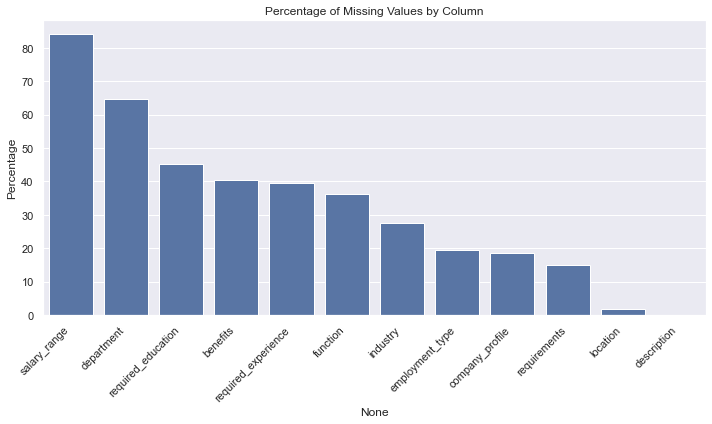

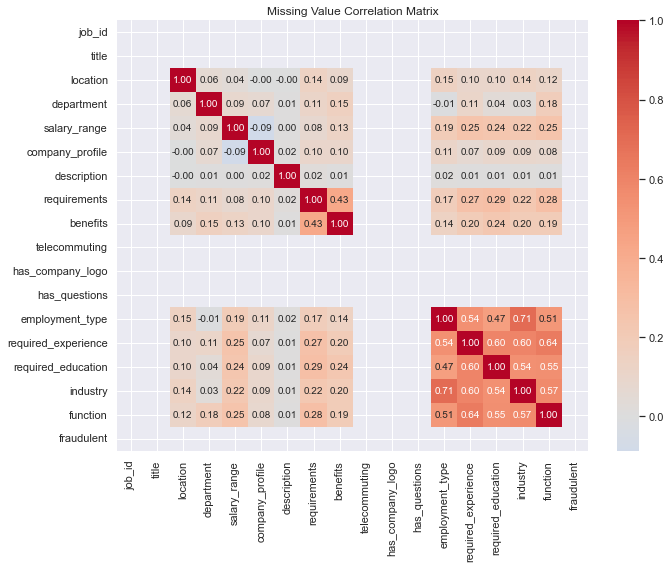


Overall Missing Value Statistics:
Total Cells: 321,840
Total Missing: 70,103
Percentage Missing: 21.78%

Target Column Value Counts and Ratio:
   Count     Ratio
0  17014  0.951566
1    866  0.048434


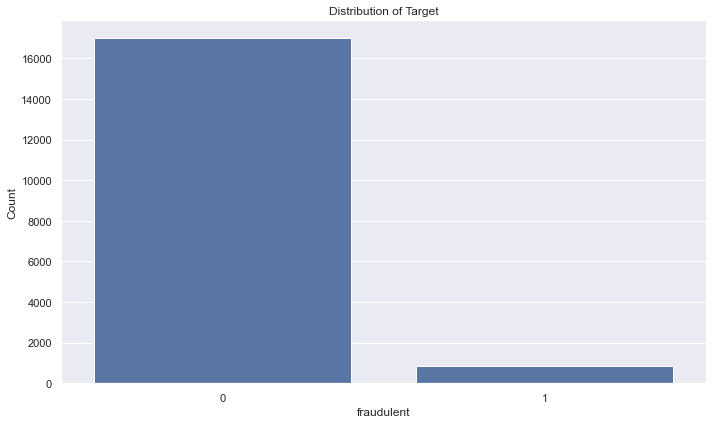

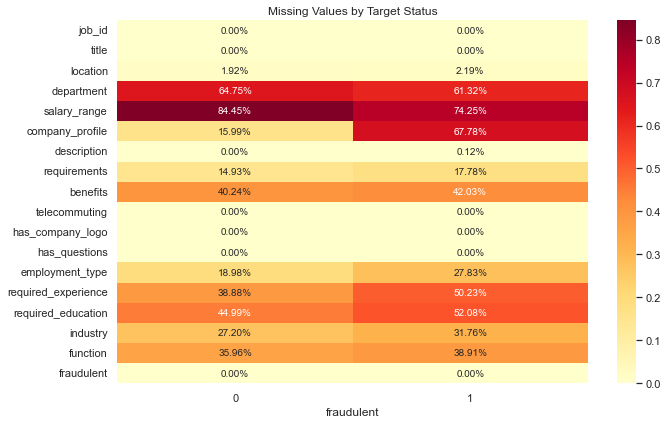


Correlations with Target Column:
fraudulent          1.000000
job_id              0.079872
telecommuting       0.034523
has_questions      -0.091627
has_company_logo   -0.261971
Name: fraudulent, dtype: float64


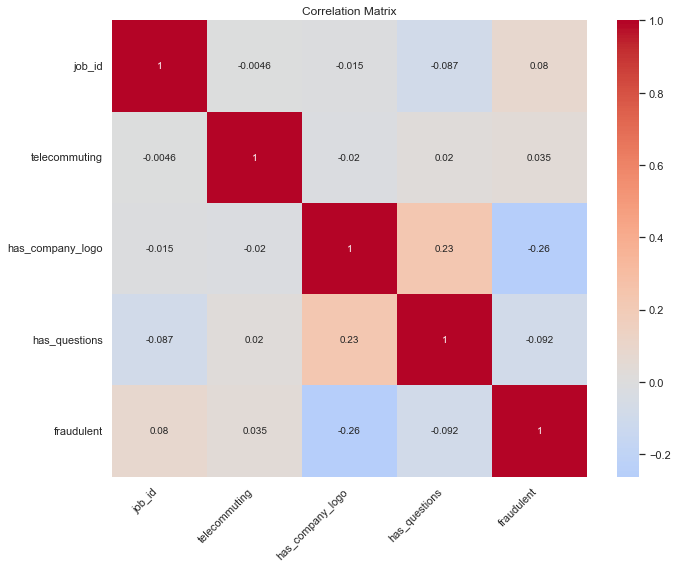


Title Length Statistics:
count    17880.000000
mean        28.530313
std         13.871256
min          3.000000
25%         19.000000
50%         25.000000
75%         35.000000
max        142.000000
Name: title_length, dtype: float64


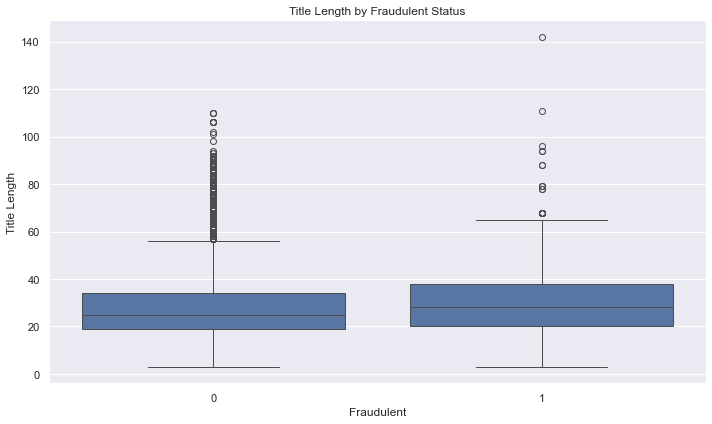


Description Length Statistics:
count    17880.000000
mean      1218.004418
std        894.828620
min          0.000000
25%        607.000000
50%       1017.000000
75%       1586.000000
max      14907.000000
Name: description_length, dtype: float64


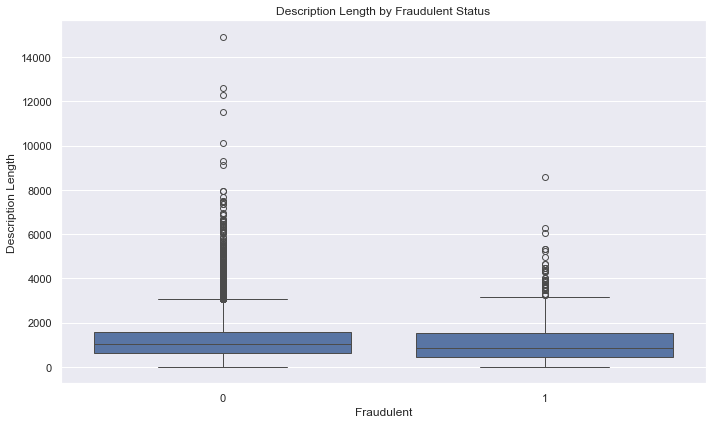


Requirements Length Statistics:
count    17880.000000
mean       590.132438
std        613.191056
min          0.000000
25%        146.000000
50%        467.000000
75%        820.000000
max      10864.000000
Name: requirements_length, dtype: float64


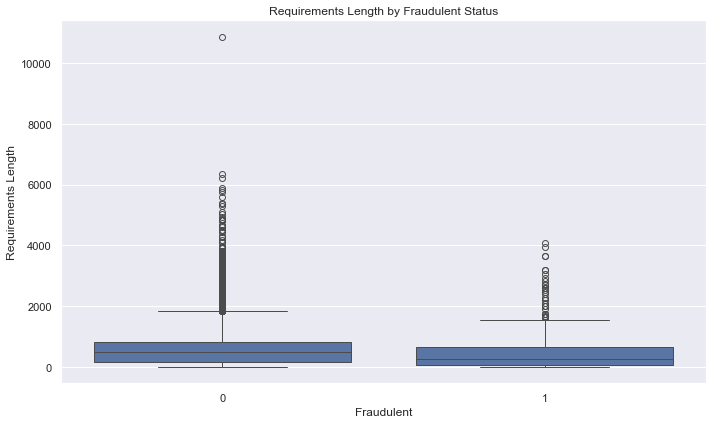


Company_Profile Length Statistics:
count    17880.000000
mean       620.901454
std        567.454100
min          0.000000
25%        138.000000
50%        570.000000
75%        879.000000
max       6178.000000
Name: company_profile_length, dtype: float64


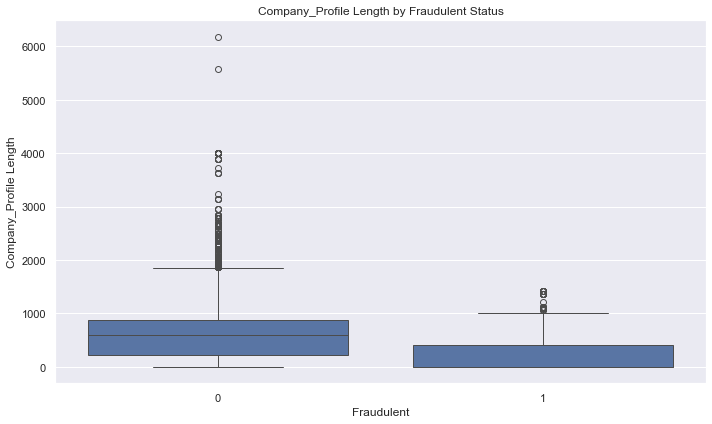


Employment_Type Value Counts:
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64


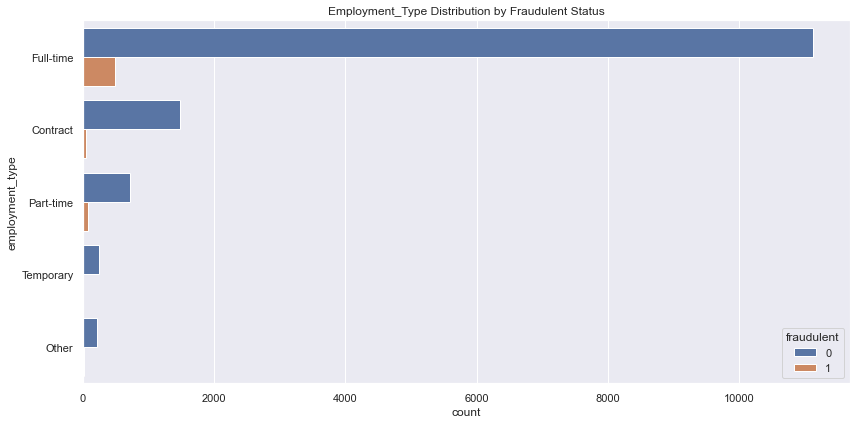


Required_Experience Value Counts:
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Name: required_experience, dtype: int64


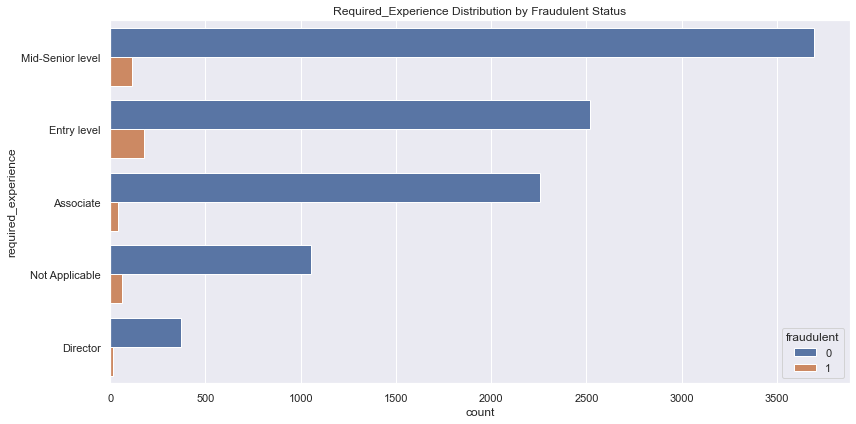


Required_Education Value Counts:
Bachelor's Degree            5145
High School or equivalent    2080
Unspecified                  1397
Master's Degree               416
Associate Degree              274
Name: required_education, dtype: int64


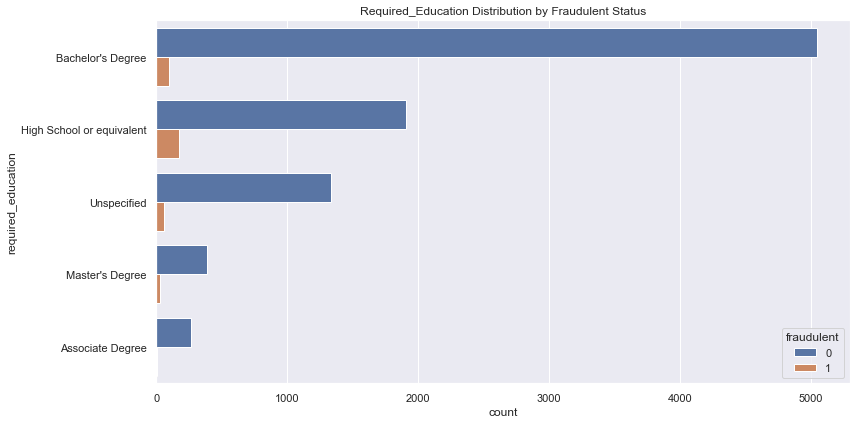


Location Value Counts:
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
Name: location, dtype: int64


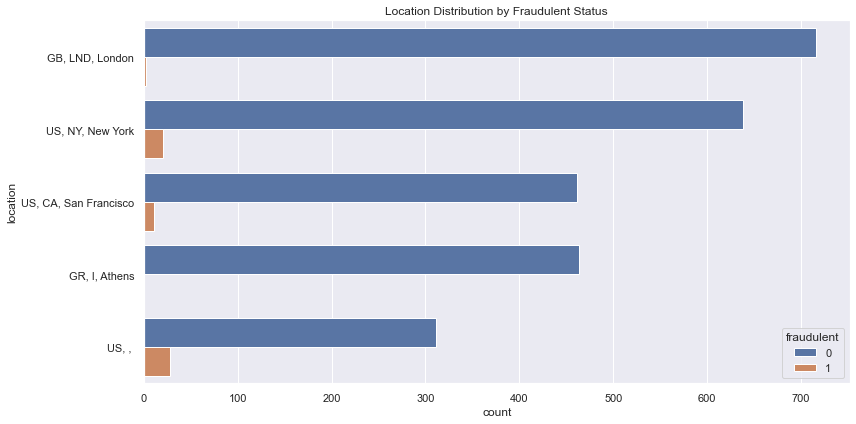

Removed 'salary_range' column due to 83% missing values.
Note: 'job_id' column should not be used for modeling, it's system identifier.

Saving processed data and feature lists...

Data analysis complete. Files saved for next steps.


In [8]:
import pandas as pd
from sklearn.pipeline import Pipeline
from fpdf import FPDF  # Library for PDF export

# Assuming DataAnalyzer, TextFeatureAnalyzer, and CategoricalFeatureAnalyzer are defined elsewhere

## 3. Create and Run Pipeline
def create_eda_pipeline():
    return Pipeline([
        ('data', DataAnalyzer(target_column='fraudulent')),
        ('target_analysis', TargetAnalyzer(target_column='fraudulent')),
        ('text_analysis', TextFeatureAnalyzer(text_columns=['title', 'description', 'requirements', 'company_profile'], target_column='fraudulent')),
        ('categorical_analysis', CategoricalFeatureAnalyzer(cat_columns=['employment_type', 'required_experience', 'required_education', 'location'], target_column='fraudulent'))
    ])


if __name__ == "__main__":
    try:
        # Load data
        print("Loading data...")
        df = pd.read_csv('data/fake_job_postings.csv')
        
        # Create and run pipeline
        print("Creating and running EDA pipeline...")
        eda_pipeline = create_eda_pipeline()
        processed_df = eda_pipeline.fit_transform(df)
        
        # Remove 'salary_range' column after pipeline execution
        if 'salary_range' in processed_df.columns:
            processed_df = processed_df.drop(columns=['salary_range'])
            print("Removed 'salary_range' column due to 83% missing values.")
        
        # Note 'job_id' column
        if 'job_id' in processed_df.columns:
            processed_df = processed_df.drop(columns=['job_id'])
            print("Note: 'job_id' column should not be used for modeling, it's system identifier.")
        
        # Save processed data and feature lists
        print("\nSaving processed data and feature lists...")
        feature_lists = {
            'text_features': ['title', 'description', 'requirements', 'company_profile'],
            'categorical_features': ['location', 'employment_type', 'required_experience', 'required_education'],
            'numeric_features': ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
        }
        
        processed_df.to_pickle('data/processed_data.pkl')
        pd.to_pickle(feature_lists, 'data/feature_lists.pkl')

        
        
        print("\nData analysis complete. Files saved for next steps.")

        
        
    except Exception as e:
        print(f"Error during data processing: {e}")
